In [1]:
# default_exp likelihood_method

In [4]:
# export
from multiinstance.data.syntheticData import buildDataset
from multiinstance.utils import *
import autograd
from autograd import grad,jacobian,hessian
from autograd.scipy import stats as agss
import autograd.numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import scipy.stats as ss
import os
from glob import glob


In [5]:
#os.sched_setaffinity(0, range(40,60))

In [6]:
# export
def logLikelihood(xi,mu,sigma,normalize):
    LL = np.sum(agss.norm.logpdf(xi,mu,sigma))
    if normalize:
        LL = LL * (1/len(xi))
    return LL

def getChildren(idx,N):
    if idx > N - 1:
        return np.array([idx])
    left = 2 * idx + 1
    right = left + 1
    
    return np.concatenate([getChildren(left,N),getChildren(right,N)])

def treeNegativeLogLikelihood(x,leafN,normalize=True,rlambda=.5):
    def LL(leafMeans,bagSigma):
        NBags = len(bagSigma)
        NInternal_Nodes = np.floor(NBags/2)
        NLeaves = len(leafMeans)
        ll = 0
        Nrows = int(np.ceil(np.log2(NLeaves))) + 1
        for row in range(Nrows):
            for col in range(2**row):
                idx = col
                if row > 0:
                    idx += 2**(row) - 1                
                leafIndices = (getChildren(idx, NInternal_Nodes) - NInternal_Nodes).astype(int)
                ln = leafN[leafIndices]
                mu = np.dot(leafMeans[leafIndices],ln)/np.sum(ln)
                sigma = bagSigma[idx]
                ll = ll + (rlambda**row) * logLikelihood(x[idx],mu,sigma,normalize)
        return -1 * ll
    return LL

In [10]:
def prepDS(dsi,numbootstraps=100,internalScale=.1, internalBias=0.0, leafScale=.25, leafBias=0):
    dsi = addTransformScores(dsi)
    dsi = addGlobalEsts(dsi)
#     dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,numbootstraps=numbootstraps)

    dsi.numLeaves = dsi.N
    dsi.numNodes = dsi.numLeaves + (dsi.numLeaves - 1)
    dsi.numInternal = dsi.numNodes - dsi.numLeaves

    dsi.mu = np.zeros(dsi.N)
    dsi.sigma = np.ones(dsi.numNodes)
    numEstimates = np.ones_like(dsi.mu) * numbootstraps
    dsi.leafN = dsi.numU
    dsi.treeAlphaHats = [[] for _ in range(dsi.numNodes)]

    for nodeNum in range(dsi.numInternal):
        children = getChildren(nodeNum, dsi.numInternal)
        leafNums = children - dsi.numInternal
        _,unlabeled = list(zip(*[getTransformScores(dsi,n) for n in leafNums]))
        pos,_ = list(zip(*[getTransformScores(dsi,n) for n in range(dsi.N)]))
        pos = np.concatenate(pos).reshape((-1,1))
        unlabeled = np.concatenate(unlabeled).reshape((-1,1))
        NEstimates = int(np.sum([numEstimates[l] for l in leafNums]))
        #dsi.treeAlphaHats[nodeNum],_ = getEsts(pos, unlabeled, NEstimates)
        leafIndices = getChildren(nodeNum, dsi.N - 1).astype(int) - (dsi.N-1)
        ln = dsi.numU[leafIndices]
        alphaTilde = np.dot(dsi.trueAlphas[leafIndices].flatten(),ln)/np.sum(ln)
        dsi.treeAlphaHats[nodeNum] = alphaTilde + internalBias + np.random.normal(scale=internalScale,
                                                                    size=NEstimates)
        _, dsi.sigma[nodeNum] = ss.norm.fit(dsi.treeAlphaHats[nodeNum])

    for leafNum in range(dsi.numLeaves):
        nodeNum = leafNum + dsi.numInternal
#         dsi.treeAlphaHats[nodeNum] = dsi.alphaHats[leafNum]
        dsi.treeAlphaHats[nodeNum] = dsi.trueAlphas[leafNum] + leafBias + np.random.normal(scale=leafScale,
                                                                               size=numbootstraps)
        dsi.mu[leafNum],dsi.sigma[nodeNum] = ss.norm.fit(dsi.treeAlphaHats[nodeNum])
    return dsi



In [11]:
# export
def runAlgorithm(dsi,normalize=True,NIter=1000,rlambda=.5, lr=.01,newton=True):

    maes = [np.mean(np.abs(dsi.mu - dsi.trueAlphas.flatten()))]

    gradNLL_mu = grad(treeNegativeLogLikelihood(dsi.treeAlphaHats,
                                                dsi.leafN,
                                                normalize=normalize,
                                                rlambda=rlambda),0)
    hessianNLL_mu = hessian(treeNegativeLogLikelihood(dsi.treeAlphaHats,
                                                dsi.leafN,
                                                normalize=normalize,
                                                rlambda=rlambda),0)
    gradNLL_sigma = grad(treeNegativeLogLikelihood(dsi.treeAlphaHats,
                                                   dsi.leafN,
                                                   normalize=normalize,
                                                   rlambda=rlambda),1)
    
    hessianNLL_sigma = hessian(treeNegativeLogLikelihood(dsi.treeAlphaHats,
                                                   dsi.leafN,
                                                   normalize=normalize,
                                                   rlambda=rlambda),1)
    mus = [dsi.mu]
    negLogLikelihood = []
    nllfunc = treeNegativeLogLikelihood(dsi.treeAlphaHats, dsi.leafN)
    sigmas = [dsi.sigma]
    for i in tqdm(range(NIter),total=NIter):
        if not i % 1500:
            lr = lr * .5
        if newton:
            deltaMu =  np.linalg.inv(hessianNLL_mu(dsi.mu,
                                                   dsi.sigma)) @ gradNLL_mu(dsi.mu,
                                                                            dsi.sigma)
            deltaSigma = np.linalg.inv(hessianNLL_sigma(dsi.mu,
                                                        dsi.sigma)) @ gradNLL_sigma(dsi.mu,
                                                                                    dsi.sigma)
        else:
            deltaMu = gradNLL_mu(dsi.mu, dsi.sigma)
            deltaSigma = gradNLL_sigma(dsi.mu,dsi.sigma)
        mus.append(dsi.mu)
        sigmas.append(dsi.sigma)
        dsi.mu = dsi.mu - lr * deltaMu
#         dsi.mu[dsi.mu <= 0] = .01
        negLogLikelihood.append(nllfunc(dsi.mu, dsi.sigma))
        dsi.sigma = dsi.sigma - lr * deltaSigma
        maes.append(np.mean(np.abs(dsi.mu - dsi.trueAlphas.flatten())))
    return dsi,mus,sigmas,maes,negLogLikelihood

def plotMAE(maes,dsi):
    fig,ax = plt.subplots()
    ax.plot(maes,label="likelihood method")
    ax.hlines(np.mean(np.abs(dsi.globalAlphaHats.mean() - dsi.trueAlphas.flatten())),
               0,len(maes),
               color="black",label="global")
    ax.set_ylabel("MAE")
    ax.legend()
    return fig

def plotDistrs(ds,mus_,sigmas_):
    Nrows = int(np.ceil(np.log2(ds.N))) + 1
    fig,ax= plt.subplots(nrows=Nrows,ncols=ds.N,figsize=(5 * ds.N,5 * ds.N))
    for row in range(Nrows):
        for col in range(2**row):
            idx = col
            if row > 0:
                idx += 2**(row) - 1
            ax[row,col].hist(ds.treeAlphaHats[idx],density=True)
            leafIndices = getChildren(idx, ds.N - 1).astype(int) - (ds.N-1)
            ln = ds.numU[leafIndices]
            # Final
            mu = np.dot(ds.mu[leafIndices],ln)/np.sum(ln)
            sigma = ds.sigma[idx]
            pdf = ss.norm.pdf(np.arange(0,
                                        ds.treeAlphaHats[idx].max(),
                                        .01),
                              loc=mu,scale=sigma)
            ax[row,col].plot(np.arange(0,
                                       ds.treeAlphaHats[idx].max(),
                                       .01),
                             pdf,color="green",alpha=.5,label="final")
            ax[row,col].vlines(mu,0,1,color="green",label="alpha hat")
            # Original
            mu = np.dot(mus_[0][leafIndices],ln)/np.sum(ln)
            sigma = sigmas_[0][idx]
            pdf = ss.norm.pdf(np.arange(0,ds.treeAlphaHats[idx].max(),.01),
                              loc=mu,scale=sigma)
            ax[row,col].plot(np.arange(0,ds.treeAlphaHats[idx].max(),.01),pdf,color="red",alpha=.5,label="og")
            truth = np.dot(ds.trueAlphas[leafIndices].flatten(), ln)/np.sum(ln)
            ax[row,col].vlines(truth,0,1,color="black",label="alpha")
            ax[row,col].legend()
    return fig

# Low variance causes problems


[0.99987039 0.66659703] [-81.97501348   6.59800416   4.87697721]


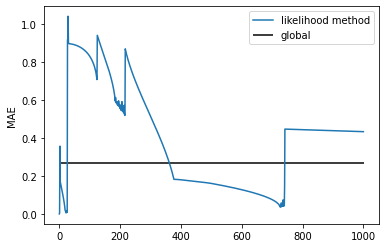

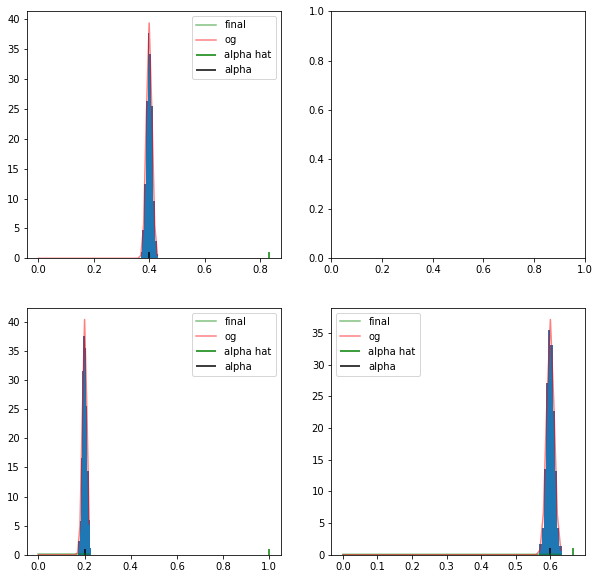

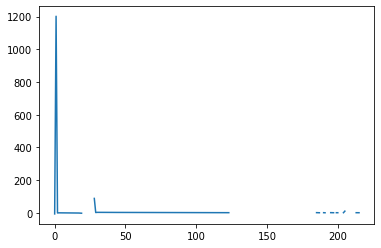

In [12]:
dsi = buildDataset(1,nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.20]))
ds2 = buildDataset(1, nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.60]))
dsi.merge(ds2)

dsi = prepDS(dsi,numbootstraps=1000,internalScale=.01,leafScale=.01,leafBias=0.00)
dsi, mus,sigmas,maes,NLL = runAlgorithm(dsi,
                                        NIter=1000,
                                        rlambda=1,lr=0.01,newton=False)
maefig1 = plotMAE(maes,dsi)
fig1 = plotDistrs(dsi,mus,sigmas)
print(dsi.mu, dsi.sigma)
fig,ax= plt.subplots()
ax.plot(NLL)

## Fixed by Newton's Method


[0.19999435 0.59999037] [0.00098072 0.00097257 0.00100867]


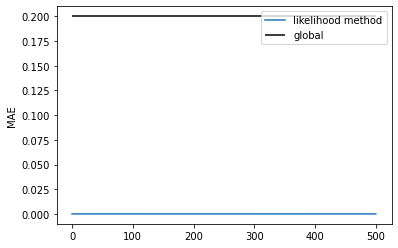

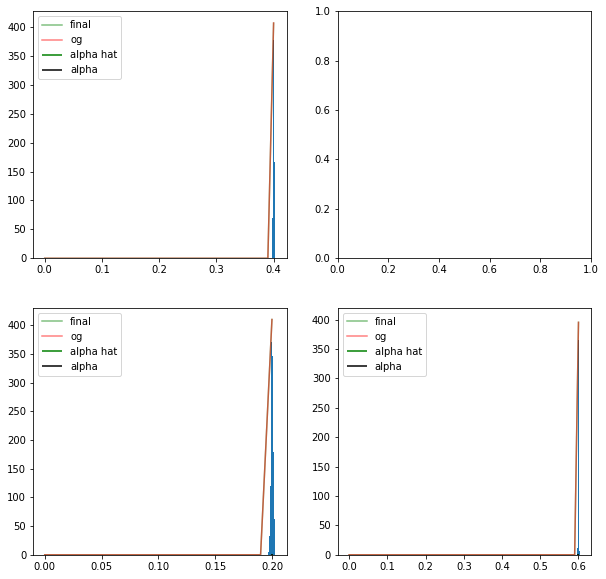

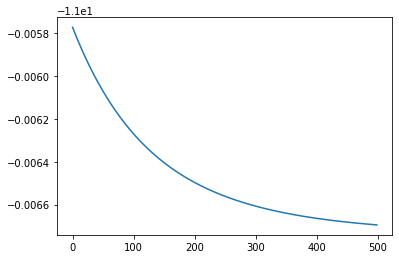

In [13]:
dsi = buildDataset(1,nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.20]))
ds2 = buildDataset(1, nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.60]))
dsi.merge(ds2)

dsi = prepDS(dsi,numbootstraps=1000,internalScale=0.001,leafScale=0.001,leafBias=0.00)
dsi, mus,sigmas,maes,NLL = runAlgorithm(dsi,
                                        NIter=500,
                                        rlambda=1,lr=0.01,newton=True)
maefig1 = plotMAE(maes,dsi)
fig1 = plotDistrs(dsi,mus,sigmas)
print(dsi.mu, dsi.sigma)

fig,ax= plt.subplots()
ax.plot(NLL)

# Bad leaf estimates: Equal Weight to internal and leaf nodes leads to bad result


[0.4482658  0.81653921] [0.02138636 0.17042899 0.18176577]


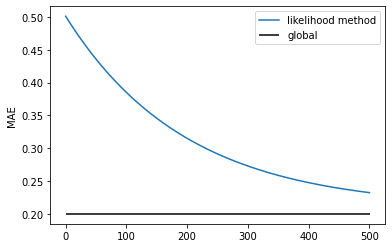

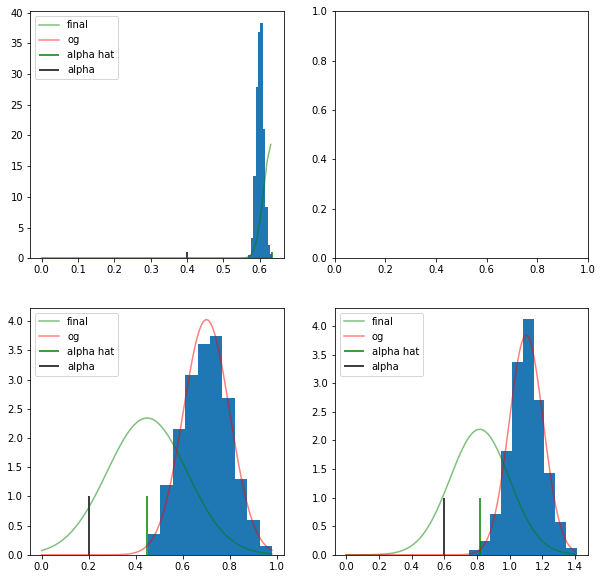

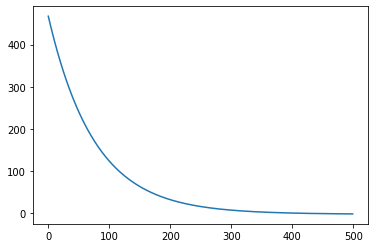

In [14]:
dsi = buildDataset(1,nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.20]))
ds2 = buildDataset(1, nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.60]))
dsi.merge(ds2)

dsi = prepDS(dsi,numbootstraps=1000,internalScale=0.01,leafScale=0.1,leafBias=0.50, internalBias=.2)
dsi, mus,sigmas,maes,NLL = runAlgorithm(dsi,
                                        NIter=500,
                                        rlambda=1,
                                        newton=True)
maefig1 = plotMAE(maes,dsi)
fig1 = plotDistrs(dsi,mus,sigmas)
print(dsi.mu, dsi.sigma)
fig,ax= plt.subplots()
ax.plot(NLL)

### Newton's Method improves stability in MAE curve, but the final MAE not great 

In [ ]:
dsi = buildDataset(1,nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.20]))
ds2 = buildDataset(1, nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.60]))
dsi.merge(ds2)

dsi = prepDS(dsi,numbootstraps=1000,internalScale=0.1,leafScale=0.1,leafBias=0.20)
dsi, mus,sigmas,maes,NLL = runAlgorithm(dsi,
                                        NIter=500,
                                        rlambda=1,
                                        newton=True)
maefig1 = plotMAE(maes,dsi)
fig1 = plotDistrs(dsi,mus,sigmas)
print(dsi.mu, dsi.sigma)
fig,ax= plt.subplots()
ax.plot(NLL)

### Resolved by reducing importance of noisy nodes

In [ ]:
dsi = buildDataset(1,nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.20]))
ds2 = buildDataset(1, nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.60]))
dsi.merge(ds2)

dsi = prepDS(dsi,numbootstraps=1000,internalScale=0.1,leafScale=0.1,leafBias=0.40)
dsi, mus,sigmas,maes,NLL = runAlgorithm(dsi,
                                                  NIter=800,
                                                  rlambda=.15)
maefig1 = plotMAE(maes,dsi)
fig1 = plotDistrs(dsi,mus,sigmas)
print(dsi.mu, dsi.sigma)
fig,ax= plt.subplots()
ax.plot(NLL)

In [ ]:
dsi = buildDataset(1,nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.20]))
ds2 = buildDataset(1, nP=10,nU=20,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.choice([.60]))
dsi.merge(ds2)

dsi = prepDS(dsi,numbootstraps=1000,internalScale=0.1,
             internalBias=.2, 
             leafScale=0.1,
             leafBias=-0.2)
dsi, mus,sigmas,maes,NLL = runAlgorithm(dsi,
                                                  NIter=800,
                                                  rlambda=1)
maefig1 = plotMAE(maes,dsi)
fig1 = plotDistrs(dsi,mus,sigmas)
print(dsi.mu, dsi.sigma)
fig,ax= plt.subplots()
ax.plot(NLL)


[ 0.55842593  0.50015648  0.73236616 -0.08400256  0.0649952   0.06755189
  0.57480935  0.21392846  0.13598921  0.00601957  0.34663194  0.72139054
  0.7615815  -0.04372593  0.40184916  0.1465744   0.33354677  0.24715545
  0.73795556 -0.03528157  0.70035552 -0.04459506  0.24816862  0.78377896
  0.70023203  0.56816438 -0.03033657  0.22021704  0.75186029 -0.01086168
  0.38347839  0.08297967] [0.12111752 0.12317017 0.11829442 0.10930458 0.12426723 0.12181428
 0.12172163 0.1288253  0.11502865 0.11008887 0.12873795 0.1209304
 0.11179005 0.11785789 0.11535504 0.12046217 0.1165606  0.12984285
 0.10779895 0.11679113 0.10670617 0.11763881 0.12512869 0.08254865
 0.09835987 0.09981067 0.12097849 0.10033951 0.11576309 0.12794267
 0.12133272 0.12555606 0.08767525 0.11078196 0.11236283 0.10248761
 0.10030428 0.09302968 0.09420296 0.09224082 0.08301095 0.0906706
 0.08584314 0.11706028 0.09649977 0.10797366 0.10806452 0.11962674
 0.09441911 0.08833333 0.11340441 0.12161294 0.11556313 0.08377139
 0.0850

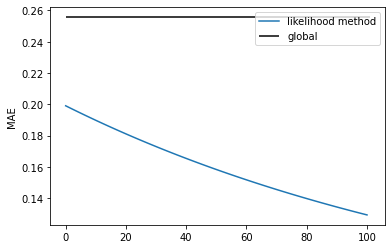

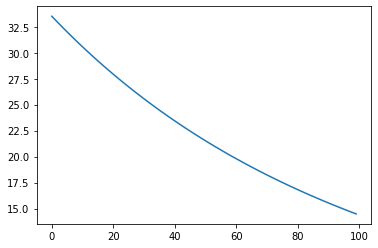

In [12]:
dsi = buildDataset(32,nP=10,nU=10,posMean=6,negMean=2,cov=1,
                   alphaDistr=lambda: np.random.uniform(low=.01,high=.95))

dsi = prepDS(dsi,numbootstraps=25,internalScale=0.1,
             internalBias=.2, 
             leafScale=0.1,
             leafBias=-0.2)
dsi, mus,sigmas,maes,NLL = runAlgorithm(dsi,
                                                  NIter=100,
                                                  rlambda=1)
maefig1 = plotMAE(maes,dsi)
fig1 = plotDistrs(dsi,mus,sigmas)
print(dsi.mu, dsi.sigma)
fig,ax= plt.subplots()

ax.plot(NLL)